In [ ]:
!pip install datasets transformers evaluate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This line can be adjusted so long as the working directory contains
# the data files found in "chai_trial_project"
cd /content/drive/MyDrive/UChicago/Career Advancement/CHAI Lab/Application/chai_trial_project

/content/drive/MyDrive/UChicago/Career Advancement/CHAI Lab/Application/chai_trial_project


In [4]:
import torch
import numpy as np
from datasets import load_dataset, ClassLabel, concatenate_datasets
from transformers import AutoTokenizer, DataCollatorWithPadding, \
AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
data_files = {
    'train': './op_task/train_op_data.jsonlist.bz2', 
    'test': './op_task/heldout_op_data.jsonlist.bz2'
}

In [6]:
persuade_data = load_dataset('json', data_files=data_files)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-c16f624fcb6ff284/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Data exploration
persuade_data

DatasetDict({
    train: Dataset({
        features: ['title', 'delta_label', 'name', 'selftext'],
        num_rows: 10743
    })
    test: Dataset({
        features: ['title', 'delta_label', 'name', 'selftext'],
        num_rows: 1529
    })
})

In [8]:
persuade_data['train'][1]

{'title': 'CMV: Iran has the right to develop nuclear weapons',
 'delta_label': False,
 'name': 't3_2rpfn7',
 'selftext': "First off, I do not believe that Iran *should* have nuclear weapons. In fact, I believe Iran having nuclear weapons makes the world less safe overall. However, I believe that as a sovereign nation they have the right to develop nuclear weapons if they so choose.\n\nWhy do I believe this:\n\n1. It is in Iran's best strategic interests to develop nuclear weapons in order to counter Israel (which has nuclear weapons), and additionally to one-up Saudi Arabia (their main regional rival), and guarantee their safety against other Arab nations with whom they have historically had rocky relations (Iraq, for example).\n2. If Israel can illegally possess nuclear weapons (they haven't officially acknowledge they have nuclear weapons, nor have they signed the UN's non-proliferation treaty, making the weapons they do possess illegal), why can't Iran possess nuclear weapons, othe

In [9]:
# Cleans up the text section of a CMV post. The code is
# borrowed from https://vene.ro/blog/winning-arguments-attitude-change-reddit-cmv.html
def cleanup(selftext):
    lines = [line for line in selftext.splitlines()
             if not line.lstrip().startswith("&gt;")
             and not line.lstrip().startswith("____")
             and "edit" not in " ".join(line.lower().split()[:2])
            ]
    return "\n".join(lines)

def clean_selftext(example):
    return {'selftext': cleanup(example['selftext'])}

In [10]:
persuade_data = persuade_data.map(clean_selftext)

  0%|          | 0/10743 [00:00<?, ?ex/s]

  0%|          | 0/1529 [00:00<?, ?ex/s]

In [11]:
persuade_data['train'][1]

{'title': 'CMV: Iran has the right to develop nuclear weapons',
 'delta_label': False,
 'name': 't3_2rpfn7',
 'selftext': "First off, I do not believe that Iran *should* have nuclear weapons. In fact, I believe Iran having nuclear weapons makes the world less safe overall. However, I believe that as a sovereign nation they have the right to develop nuclear weapons if they so choose.\n\nWhy do I believe this:\n\n1. It is in Iran's best strategic interests to develop nuclear weapons in order to counter Israel (which has nuclear weapons), and additionally to one-up Saudi Arabia (their main regional rival), and guarantee their safety against other Arab nations with whom they have historically had rocky relations (Iraq, for example).\n2. If Israel can illegally possess nuclear weapons (they haven't officially acknowledge they have nuclear weapons, nor have they signed the UN's non-proliferation treaty, making the weapons they do possess illegal), why can't Iran possess nuclear weapons, othe

In [26]:
# All of the models used in experiments

checkpoint = 'bert-base-uncased'
# checkpoint = 'bert-base-cased'
# checkpoint = 'distilbert-base-uncased'
# checkpoint = 'distilbert-base-cased'
# checkpoint = 'allenai/longformer-base-4096'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [27]:
# A function that tokenizes the examples' selftexts
# that can be mapped over the data splits
def tokenize_func(example):
    return tokenizer(example['selftext'], truncation=True)

In [28]:
# Tokenizes the data
token_data = persuade_data.map(tokenize_func)

  0%|          | 0/10743 [00:00<?, ?ex/s]

  0%|          | 0/1529 [00:00<?, ?ex/s]

In [29]:
token_data

DatasetDict({
    train: Dataset({
        features: ['title', 'delta_label', 'name', 'selftext', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10743
    })
    test: Dataset({
        features: ['title', 'delta_label', 'name', 'selftext', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1529
    })
})

In [30]:
# Checking the lengths of processed samples. The lengths will be truncated
# for BERT-based models and remain unchanged for the Longformer.
token_data = token_data.map(lambda x: {'length': len(x['input_ids'])})

  0%|          | 0/10743 [00:00<?, ?ex/s]

  0%|          | 0/1529 [00:00<?, ?ex/s]

In [31]:
data_lengths = token_data['train']['length']

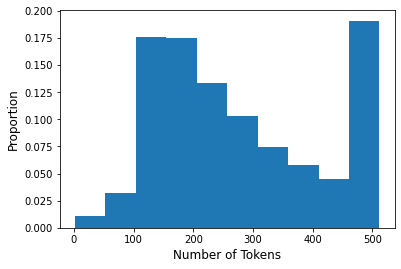

In [32]:
# Possible text lengths under BERT-based models
Path('./plots/').mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots()

num_pts = len(data_lengths)
wts = [1 / num_pts for length in data_lengths]
ax.hist(data_lengths, weights=wts)

ax.set_xlabel('Number of Tokens', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
fig.savefig('./plots/bert_tokens.png', bbox_inches='tight')

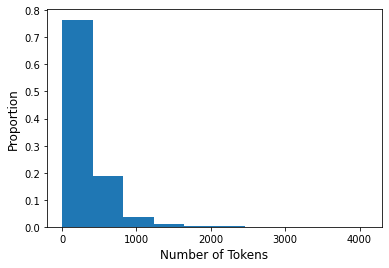

In [25]:
# Possible text lengths under Longformer
Path('./plots/').mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots()

num_pts = len(data_lengths)
wts = [1 / num_pts for length in data_lengths]
ax.hist(data_lengths, weights=wts)

ax.set_xlabel('Number of Tokens', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
fig.savefig('./plots/longformer_tokens.png', bbox_inches='tight')

In [ ]:
# Processing the columns to be recognizable by the model
token_data = token_data.remove_columns(['title','name','selftext','length'])
token_data = token_data.rename_column('delta_label','labels')

In [ ]:
# Re-formatting the labels from scalar to 2-D vectors so that
# they are compatible with the model's output. This step is
# necessary to compute the loss
mall_label = ClassLabel(num_classes=2, names=['fixed', 'malleable'])
token_data = token_data.cast_column('labels', mall_label)

Casting the dataset:   0%|          | 0/11 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
token_data['train'].features

{'labels': ClassLabel(names=['fixed', 'malleable'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
# Fixing class imbalance for the train set by under-sampling
train_pos = token_data['train'].filter(lambda x: x['labels'] == 1)
train_neg = token_data['train'].filter(lambda x: x['labels'] == 0)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
train_neg = train_neg.select(range(3191))

In [ ]:
train_balance = concatenate_datasets([train_pos, train_neg])
train_balance = train_balance.shuffle(seed=42)
token_data['train'] = train_balance

In [ ]:
token_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6382
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1529
    })
})

In [ ]:
# The data collator batches samples together
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Loading a new model from HuggingFace
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Loading a finetuned model from a checkpoint
# model = AutoModelForSequenceClassification.from_pretrained('./models/distilbert-base-cased/checkpoint-4500')
model = AutoModelForSequenceClassification.from_pretrained('./models/allenai/longformer-base-4096/checkpoint-2000')

In [ ]:
# Freezing the BERT parameters to avoid destroying the pretrained weights
# for param in model.bert.parameters():
#   param.requires_grad = False

# For DistilBERT
# for param in model.distilbert.parameters():
#   param.requires_grad = False

# For Longformer
for param in model.longformer.parameters():
  param.requires_grad = False

In [ ]:
# Freezing only the word embeddings
# for param in model.bert.embeddings.parameters():
#   param.requires_grad = False

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load('roc_auc')
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(references=labels, prediction_scores=predictions)

In [ ]:
train_args = TrainingArguments('./models/' + checkpoint, evaluation_strategy='epoch', num_train_epochs=3, learning_rate=1e-06)
# train_args = TrainingArguments('./models/' + checkpoint + '-final', evaluation_strategy='epoch', num_train_epochs=3, learning_rate=1e-05)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model, 
    train_args, 
    train_dataset=token_data['train'],
    eval_dataset=token_data['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# Training Longformer for 6 epochs (first 3 not shown). The best performance is 
# achieved at 5 epochs, despite the losses' decrease on the 6th epoch
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6382
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2394
  Number of trainable parameters = 592130
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Initializing global attention on CLS token...
Input ids are automatically padded from 1313 to 1536 to be a multiple of `config.attention_window`: 512


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.691000,0.697915,0.503645
2,0.690700,0.692556,0.547708
3,0.690400,0.691849,0.538342


Initializing global attention on CLS token...
Input ids are automatically padded from 602 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 533 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 616 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 589 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 594 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 477 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 1052 to 1536 to be a 

Initializing global attention on CLS token...
Input ids are automatically padded from 571 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 657 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 880 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 334 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 718 to 1024 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 559 to 1024 to be a mu

TrainOutput(global_step=2394, training_loss=0.6908350970810816, metrics={'train_runtime': 2811.2491, 'train_samples_per_second': 6.81, 'train_steps_per_second': 0.852, 'total_flos': 9691309272105168.0, 'train_loss': 0.6908350970810816, 'epoch': 3.0})

In [ ]:
# Training DistilBERT-cased for 3 epochs
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6382
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2394
  Number of trainable parameters = 592130


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.694500,0.700485,0.500583
2,0.691500,0.692174,0.530840
3,0.693000,0.691573,0.535383


Saving model checkpoint to ./models/distilbert-base-cased-final/checkpoint-500
Configuration saved in ./models/distilbert-base-cased-final/checkpoint-500/config.json
Model weights saved in ./models/distilbert-base-cased-final/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./models/distilbert-base-cased-final/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./models/distilbert-base-cased-final/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1529
  Batch size = 8
Saving model checkpoint to ./models/distilbert-base-cased-final/checkpoint-1000
Configuration saved in ./models/distilbert-base-cased-final/checkpoint-1000/config.json
Model weights saved in ./models/distilbert-base-cased-final/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./models/distilbert-base-cased-final/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./models/distilbert-base-cased-final/checkpoint-1000/special_tok

TrainOutput(global_step=2394, training_loss=0.6928088985688505, metrics={'train_runtime': 425.0682, 'train_samples_per_second': 45.042, 'train_steps_per_second': 5.632, 'total_flos': 2439252091597704.0, 'train_loss': 0.6928088985688505, 'epoch': 3.0})

In [ ]:
# Result of training BERT-uncased for 3 epochs
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6382
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2394
  Number of trainable parameters = 1538
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.700400,0.695308,0.509149
2,0.696200,0.689593,0.522465
3,0.696100,0.688974,0.514205


Saving model checkpoint to ./models/bert-base-uncased/checkpoint-500
Configuration saved in ./models/bert-base-uncased/checkpoint-500/config.json
Model weights saved in ./models/bert-base-uncased/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./models/bert-base-uncased/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./models/bert-base-uncased/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1529
  Batch size = 8
Saving model checkpoint to ./models/bert-base-uncased/checkpoint-1000
Configuration saved in ./models/bert-base-uncased/checkpoint-1000/config.json
Model weights saved in ./models/bert-base-uncased/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./models/bert-base-uncased/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./models/bert-base-uncased/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./models/bert-base-uncased/checkpoint-1500
Configuration sav

TrainOutput(global_step=2394, training_loss=0.6970056391997246, metrics={'train_runtime': 915.474, 'train_samples_per_second': 20.914, 'train_steps_per_second': 2.615, 'total_flos': 4823685894566520.0, 'train_loss': 0.6970056391997246, 'epoch': 3.0})

In [ ]:
# Note: this is the result after training DistilBERT-cased for 18 epochs
# (first 12 epochs not shown)
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6382
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4788
  Number of trainable parameters = 592130


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.685400,0.691872,0.525937
2,0.685500,0.691666,0.525717
3,0.687700,0.691480,0.524914
4,0.686400,0.691522,0.524491
5,0.688100,0.691648,0.526300
6,0.687300,0.691384,0.527510


Saving model checkpoint to ./models/distilbert-base-cased/checkpoint-500
Configuration saved in ./models/distilbert-base-cased/checkpoint-500/config.json
Model weights saved in ./models/distilbert-base-cased/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./models/distilbert-base-cased/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./models/distilbert-base-cased/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1529
  Batch size = 8
Saving model checkpoint to ./models/distilbert-base-cased/checkpoint-1000
Configuration saved in ./models/distilbert-base-cased/checkpoint-1000/config.json
Model weights saved in ./models/distilbert-base-cased/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./models/distilbert-base-cased/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./models/distilbert-base-cased/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./models/distilbert-

TrainOutput(global_step=4788, training_loss=0.6874170422852787, metrics={'train_runtime': 945.3255, 'train_samples_per_second': 40.507, 'train_steps_per_second': 5.065, 'total_flos': 4868310920358984.0, 'train_loss': 0.6874170422852787, 'epoch': 6.0})

In [ ]:
# BOW baseline. Code borrowed from https://vene.ro/blog/winning-arguments-attitude-change-reddit-cmv.html

# load the data
import tarfile
import os.path
import json
import re
from bz2 import BZ2File
from urllib import request
from io import BytesIO

import numpy as np


fname = "cmv.tar.bz2"
url = "https://chenhaot.com/data/cmv/" + fname

# download if not exists
if not os.path.isfile(fname):
    f = BytesIO()
    with request.urlopen(url) as resp, open(fname, 'wb') as f_disk:
        data = resp.read()
        f_disk.write(data)  # save to disk too
        f.write(data)
        f.seek(0)
else:
    f = open(fname, 'rb')


tar = tarfile.open(fileobj=f, mode="r")

# Extract the file we are interested in
train_fname = "op_task/train_op_data.jsonlist.bz2"
test_fname = "op_task/heldout_op_data.jsonlist.bz2"

train_bzlist = tar.extractfile(train_fname)

# Deserialize the JSON list
original_posts_train = [
    json.loads(line.decode('utf-8'))
    for line in BZ2File(train_bzlist)
]

test_bzlist = tar.extractfile(test_fname)

original_posts_test = [
    json.loads(line.decode('utf-8'))
    for line in BZ2File(test_bzlist)
]
f.close()

In [ ]:
is_malleable = np.array([post["delta_label"] for post in original_posts_train])
is_malleable_test = np.array([post["delta_label"] for post in original_posts_test])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV

# prepare the data in Python list form
op_text_train = [
    cleanup(original_post['selftext'])
    for original_post
    in original_posts_train
]

op_text_test = [
    cleanup(original_post['selftext'])
    for original_post
    in original_posts_test
]

In [ ]:
vect = TfidfVectorizer(use_idf=False, norm='l1')
X_train = vect.fit_transform(op_text_train)

In [ ]:
lr = LogisticRegressionCV(Cs=10, class_weight='balanced',
                          scoring='roc_auc', solver='sag',
                          tol=0.001, max_iter=500,
                          random_state=0)

In [ ]:
lr.fit(X_train, is_malleable)

LogisticRegressionCV(class_weight='balanced', max_iter=500, random_state=0,
                     scoring='roc_auc', solver='sag', tol=0.001)

In [ ]:
# Evaluating on the heldout data
X_test = vect.transform(op_text_test)
test_roc = lr.score(X_test, is_malleable_test)
print("Test ROC AUC score: {:.3f}".format(test_roc))

Test ROC AUC score: 0.531
